In [1]:
import os
import random
from tqdm.notebook import tqdm
from IPython.display import HTML
from base64 import b64encode

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras


import warnings
warnings.filterwarnings('ignore')

C:\Users\USER\AppData\Local\Temp\ipykernel_15412\3681367040.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24576)])  # Limit GPU memory to 8GB
    except RuntimeError as e:
        print(e)


In [3]:
# import tensorflow as tf

# # Disable GPU devices
# tf.config.set_visible_devices([], 'GPU')


###

In [4]:
import pandas as pd

# Reading data folders
TRAIN_DATA_PATH = r"G:\Mahi\demo\train"
VAL_DATA_PATH = r"G:\Mahi\demo\test"

# Reading data files
df_train = pd.read_excel(r"G:\Mahi\demo\train\train.xlsx")
df_val = pd.read_excel(r"G:\Mahi\demo\test\test.xlsx")

# # Reading vocabulary list
# df_vocab = pd.read_csv(r"F:\NasimaMam\Safi\NewTrain\vocabulary.txt", header=None)


In [5]:
# Display first n rows
df_train.head()

,file_name,class
0,1.mp4,0
1,2.mp4,0
2,3.mp4,0
3,4.mp4,0
4,5.mp4,0


In [6]:
# Display first n words in vocabulary:
df_val.head()

,file_name,class
0,1.mp4,0
1,2.mp4,0
2,3.mp4,0
3,4.mp4,0
4,5.mp4,0


In [7]:
# Checking training and validation images count
print("Training Images    : ", len(os.listdir(TRAIN_DATA_PATH)))
print("Validation Images  : ", len(os.listdir(VAL_DATA_PATH)), "\n")

# Checking training and validation dataset dimensions
print("Training   :", df_train.shape)
print("Validation :", df_val.shape)

# Checking vocabulary
# print("Vocabulary :", df_vocab.shape)

Training Images    :  2402
Validation Images  :  602 

Training   : (2400, 2)
Validation : (600, 2)


In [8]:
df_val.head()

,file_name,class
0,1.mp4,0
1,2.mp4,0
2,3.mp4,0
3,4.mp4,0
4,5.mp4,0


In [9]:
# Checking files and dropping rows from dataframe if particular data is not readable

# checking training files
train_files = os.listdir(TRAIN_DATA_PATH)
df = df_train
for file_name in df_train['file_name']:
    if file_name not in train_files:
        df=df.drop(df[df['file_name']==file_name].index)

df_train = df
print("Cleaned Training   :", df_train.shape)

# checking validation files
val_files = os.listdir(VAL_DATA_PATH)
df = df_val
for file_name in df_val['file_name']:
    if file_name not in val_files:
        df=df.drop(df[df['file_name']==file_name].index)

df_val = df
print("Cleaned Validation :", df_val.shape)

Cleaned Training   : (2400, 2)
Cleaned Validation : (600, 2)


In [10]:
def show_video(video_path):
  """
  https://stackoverflow.com/a/61569761
  Function to show a video, given the path
  """

  mp4 = open(video_path,'rb').read()
  decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f'<video width=400 controls><source src={decoded_vid} type="video/mp4"></video>')

In [11]:
# Check if df_train is not empty
if not df_train.empty:
    print("Random Sample from dataset\n")
    random_row = df_train.iloc[random.choice(range(len(df_train)))]
    video_file_path = os.path.join(TRAIN_DATA_PATH, random_row[0])
    print("Word  :  ", random_row[1])
    show_video(video_file_path)
else:
    print("The DataFrame df_train is empty. Please make sure it contains data.")

Random Sample from dataset

Word  :   0


Random Sample from dataset

Word  :   0


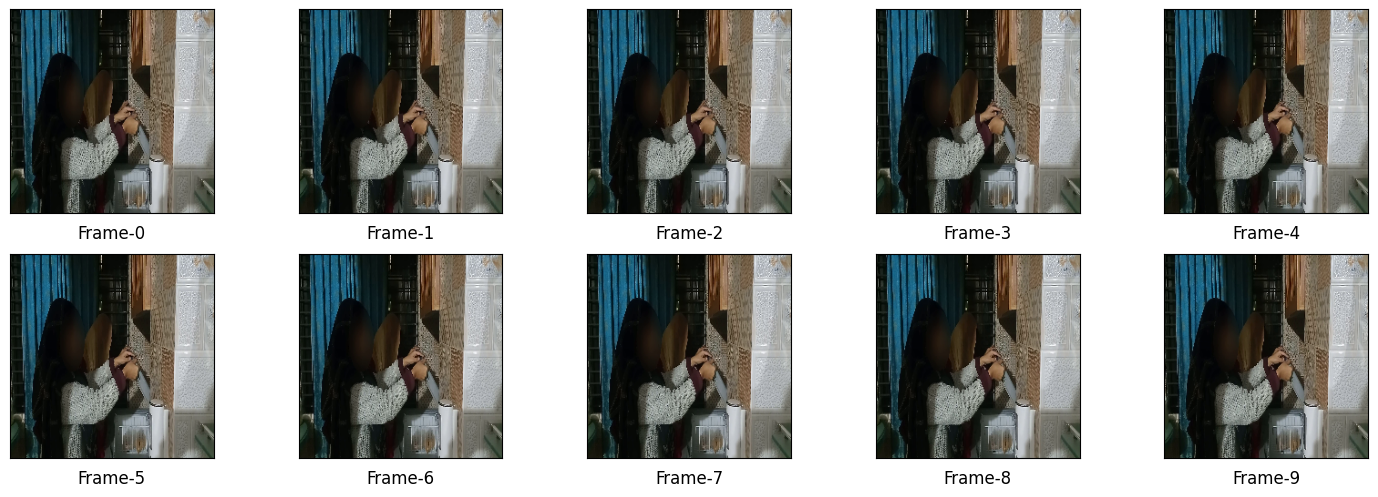

In [12]:
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Function to read the first 10 frames of input video
def read_video_frames(video_file_path):
    frames = []
    try:
        cap = cv2.VideoCapture(video_file_path)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224,224))
        frames.append(frame)
    except:
        pass

    while ret:
        try:
            ret, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        except:
            continue

    return frames[:10]


# Function to plot frames of a video
def plot_video(video_file_path, cols=5, ht=18):
    video_frames = read_video_frames(video_file_path)
    FRAMES = 10
    COLS = 5
    ROWS = (FRAMES // COLS) + 1
    fig = plt.figure(figsize=(ht, 3 * ROWS))
    for idx in range(FRAMES):
        ax = fig.add_subplot(ROWS, COLS, idx + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(video_frames[idx])
        ax.text(0.5, -0.1, f'Frame-{str(idx):s}', size=12, horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes)


print("Random Sample from dataset\n")
random_row = df_train.iloc[random.choice(range(len(df_train)))]
print("Word  :  ", random_row[1])
plot_video(TRAIN_DATA_PATH + "\\" + random_row[0])
plt.show()


###

  0%|          | 0/2402 [00:00<?, ?it/s]

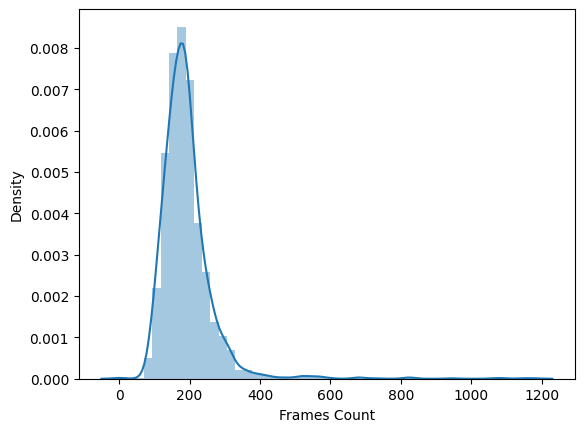

In [13]:
def get_frames_count(video_file_path):
    cap = cv2.VideoCapture(video_file_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return length



frames_dist = []
for file in tqdm(os.listdir(TRAIN_DATA_PATH)):
    frames_dist.append(get_frames_count(TRAIN_DATA_PATH + "\\" +file))

sns.distplot(frames_dist, kde=True)
plt.xlabel("Frames Count")
plt.show()

##

In [14]:
# Setting max number of frames to be extracted from each video

MAX_FRAMES = 60

In [15]:
import cv2
import os
import numpy as np

# Define the extract_hand_roi function
def extract_hand_roi(video_path):
    # Initialize an empty list to store hand movement frames
    hand_frames = []

    cap = cv2.VideoCapture(video_path)
    # Define parameters
    start_frame = 0  # Start frame for hand movement
    end_frame = 60   # End frame for hand movement (adjust as needed)
    frame_count = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # Resize the frame to a consistent size (e.g., 64x64)
        frame = cv2.resize(frame, (224, 224))

        # Append the frame to the list as a NumPy array
        hand_frames.append(frame)

        frame_count += 1

        if frame_count > end_frame:
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert the list of frames into a NumPy array
    hand_frames = np.array(hand_frames)

    return hand_frames


In [16]:
# # Function to read all the MAX_FRAMES number of frames from the video
# # Using the ROI coordinated from face exytraction model
# # Finally grayscaling the frames
# def video_to_frames(video_file_path, max_frames=30, image_size=(720, 1080), roi_hand=None):
#     frames = []
#     try:
#         cap = cv2.VideoCapture(video_file_path)
#         while len(frames) < max_frames:
#             ret, frame = cap.read()
#             if not ret:
#                 break
            
#             if roi_hand is not None:
#                 xmin, ymin, width, height = roi_hand
#                 frame = frame[ymin:ymin + height, xmin:xmin + width]
            
#             frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB color space
#             frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR color space (necessary for some systems)
#             frame = cv2.resize(frame, image_size)
            
#             frames.append(frame)
#     except cv2.error as e:
#         print(f"OpenCV error: {e}")
#     except Exception as e:
#         print(f"An error occurred: {e}")

#     while len (frames) < max_frames:
#         frames.append(np.zeros(image_size, dtype=np.uint8))

#     frames = np.array(frames)
#     assert frames.shape[0] == max_frames, "Frames Count != MAX_FRAMES"
#     return frames


Random Sample from Processed dataset - Hand Extracted

Word  :   0


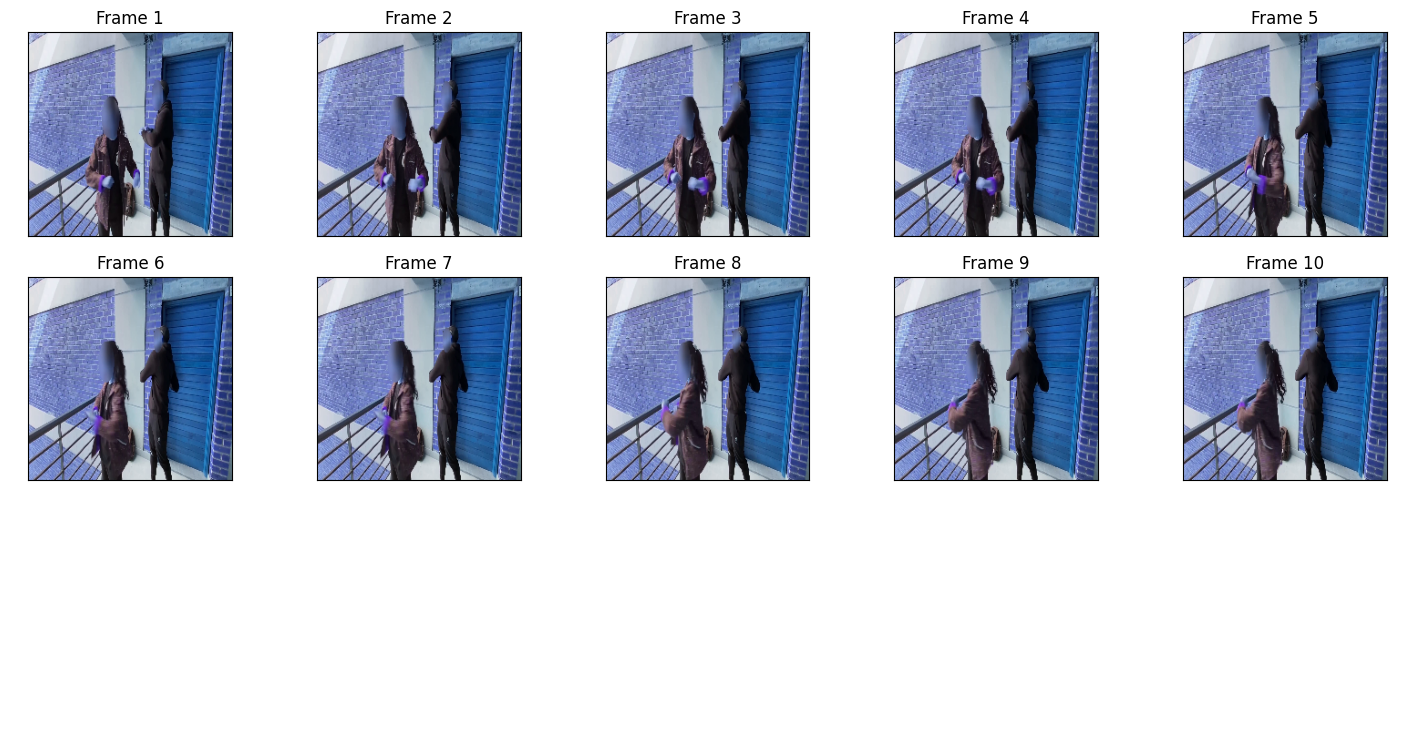

In [17]:
# Function to plot frames of a video
def plot_video(video_file_path, max_frames=10, cols=5, ht=18):
    try:
        roi_hand = extract_hand_roi(video_file_path)
        num_frames = len(roi_hand)

        if num_frames == 0:
            print("No hand movement frames found in the video.")
            return

        # Adjust the number of displayed frames
        max_frames = min(max_frames, num_frames)

        ROWS = (max_frames // cols) + 1
        fig, axes = plt.subplots(ROWS, cols, figsize=(ht, 3 * ROWS))

        for idx, ax in enumerate(axes.flatten()):
            if idx < max_frames:
                frame = roi_hand[idx]
                ax.set_xticks([])
                ax.set_yticks([])
                ax.imshow(frame)
                ax.set_title(f'Frame {idx + 1}')

        for ax in axes.flatten()[max_frames:]:
            ax.axis('off')

        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")

# Rest of your code
print("Random Sample from Processed dataset - Hand Extracted\n")
random_row = df_train.iloc[random.choice(range(len(df_train)))]
print("Word  :  ", random_row[1])
plot_video(TRAIN_DATA_PATH + "\\" + random_row[0], max_frames=10)
plt.show()


In [18]:
# Processing training data and writing to disk
# Define Constants and Directories
TRAINVIDEOS_BASE_DIR = r"G:\Mahi\demo\trainv"  

# Create Directories
try:
    os.mkdir(TRAINVIDEOS_BASE_DIR)
    print("BASE_DIR Created")
except FileExistsError:
    pass

# Process Videos and Save Frames
for video in tqdm(df_train['file_name']):
    file_name = os.path.join(TRAIN_DATA_PATH, video)
    video_dir = os.path.join(TRAINVIDEOS_BASE_DIR, str(video))

    try:
        os.mkdir(video_dir)
    except FileExistsError:
        continue

    hand_frames = extract_hand_roi(file_name)

    for idx, frame in enumerate(hand_frames):
        PIL_image = Image.fromarray(frame.astype('uint8'))
        PIL_image.save(video_dir + "\\" + f'{idx:02d}' + ".png")

  0%|          | 0/2400 [00:00<?, ?it/s]

In [19]:
# Processing validation data and writing to disk
# Define Constants and Directories
VALVIDEOS_BASE_DIR = r"G:\Mahi\demo\testv"  

# Create Directories
try:
    os.mkdir(VALVIDEOS_BASE_DIR)
    print("BASE_DIR Created")
except FileExistsError:
    pass

# Process Videos and Save Frames
for video in tqdm(df_val['file_name']):
    file_name = os.path.join(VAL_DATA_PATH, video)
    video_dir = os.path.join(VALVIDEOS_BASE_DIR, str(video))

    try:
        os.mkdir(video_dir)
    except FileExistsError:
        continue

    hand_frames = extract_hand_roi(file_name)

    for idx, frame in enumerate(hand_frames):
        PIL_image = Image.fromarray(frame.astype('uint8'))
        PIL_image.save(video_dir + "\\" + f'{idx:02d}' + ".png")

  0%|          | 0/600 [00:00<?, ?it/s]

In [20]:
import os

TRAINVIDEOS_BASE_DIR = r"G:\Mahi\demo\trainv"
df_train['file_name'] = TRAINVIDEOS_BASE_DIR + os.sep + df_train['file_name'].astype(str) + os.sep
df_train['class'] = df_train['class']
df_train.head(3)


,file_name,class
0,G:\Mahi\demo\trainv\1.mp4\,0
1,G:\Mahi\demo\trainv\2.mp4\,0
2,G:\Mahi\demo\trainv\3.mp4\,0


In [21]:
import os

VALVIDEOS_BASE_DIR = r"G:\Mahi\demo\testv"
df_val['file_name'] = VALVIDEOS_BASE_DIR + os.sep + df_val['file_name'].astype(str)+ os.sep
df_val['class'] = df_val['class']
df_val.head(3)


,file_name,class
0,G:\Mahi\demo\testv\1.mp4\,0
1,G:\Mahi\demo\testv\2.mp4\,0
2,G:\Mahi\demo\testv\3.mp4\,0


In [22]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_virtual_device_configuration(
#                 gpu,
#                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Limit GPU memory to 4GB
#     except RuntimeError as e:
#         print(e)

##

In [23]:
class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self, df, X_col, y_col, num_classes, input_size, batch_size, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.num_classes = num_classes  # Add num_classes as an argument
        self.input_size = input_size
        self.max_frames = input_size[0]
        self.image_size = input_size[1]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.n_words = df[y_col].nunique()


    def on_epoch_end(self):
        # Shuffling data after each epoch
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        # Returns num of batches
        return self.n // self.batch_size


    def __get_frames(self, video_path):
    # Reads frames from the video folder until there are no more frames
        frames_lst = []

        for i in range(60):  # Assuming you want 60 frames
            frame_name = f"{i:02d}.png"  # Format the frame name as "00.png" to "60.png"
            file_name = os.path.join(video_path, frame_name)
            frame = cv2.imread(file_name)
            if frame is not None:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frames_lst.append(frame)
            else:
            # If there are no more frames, break the loop
                break
    
    # If there are fewer than 60 frames, you can handle this case here
        while len(frames_lst) < 60:
        # You can add blank frames or duplicate the last frame, depending on your preference
        # In this example, let's add blank (all-black) frames
            blank_frame = np.zeros_like(frames_lst[0])  # Create a black frame of the same size
            frames_lst.append(blank_frame)

        return np.array(frames_lst)
    
    def __get_input(self, path):
        # Returns of frames from video file
#         print(f"Processing video: {path}")
    
        video_frames = self.__get_frames(path)
    
#         print(f"Shape of video_frames: {video_frames.shape}")
    
        return video_frames / 255.


    def __get_output(self, label):
        # Encodes label using one-hot encoding
        return tf.keras.utils.to_categorical(label, num_classes=self.num_classes)



    def __get_data(self, batches):
#         print("Debugging __get_data")
        path_batch = batches[self.X_col]
        word_batch = batches[self.y_col]
    
#         # Print a few file paths to check if they are valid
#         print("Sample file paths:")
#         for path in path_batch[:5]:
#             print(path)

#         # Print a few labels to verify they are correct
#         print("Sample labels:")
#         for label in word_batch[:5]:
#             print(label)

        X_batch = np.asarray([self.__get_input(path) for path in path_batch])
        Y_batch = np.asarray([self.__get_output(word) for word in word_batch])

        # Print shapes to ensure they are not empty
#         print("X_batch shape:", X_batch.shape)
#         print("Y_batch shape:", Y_batch.shape)

        return X_batch, Y_batch


    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)

        # Debugging: Print shapes and data types
#         print("X_batch shape:", X.shape)
#         print("Y_batch shape:", y.shape)
        

        return X, y

In [24]:
# dimensions of the batch

TARGET_SIZE = (MAX_FRAMES, 224, 224, 1)


# number of images per batch
BATCH_SIZE = 4
NUM_CLASSES = 2
# creating the training images generator
train_gen = CustomDataGen(df_train, 'file_name', 'class', NUM_CLASSES,
                          input_size=TARGET_SIZE,
                          batch_size=BATCH_SIZE)

# creating the validation images generator
val_gen = CustomDataGen(df_val, 'file_name', 'class', NUM_CLASSES,
                          input_size=TARGET_SIZE,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [25]:
random_sample_batch_imgs, random_sample_batch_labels = train_gen.__getitem__(random.choice(range(20)))

print("X_train shape:", random_sample_batch_imgs.shape)
print("Y_train shape:", random_sample_batch_labels.shape)

X_train shape: (4, 60, 224, 224)
Y_train shape: (4, 2)


In [35]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Specify the path to save the best model weights
checkpoint_filepath = 'G:/Mahi/demo/testv/cnn_best_weights.h5'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
# Set up the ModelCheckpoint callback to save weights with the highest validation accuracy
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, BatchNormalization, GlobalAveragePooling3D, Flatten, Dropout

model = Sequential()
model.add(keras.Input((20,224,224,1)))
model.add(Conv3D(filters=64, kernel_size=2, activation="relu"))
model.add(MaxPool3D(pool_size=2))
model.add(BatchNormalization())

# model.add(Conv3D(filters=128, kernel_size=2, activation="relu"))
# model.add(BatchNormalization())

model.add(Conv3D(filters=256, kernel_size=2, activation="relu"))
model.add(MaxPool3D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv3D(filters=256, kernel_size=2, activation="relu"))
model.add(MaxPool3D(pool_size=(1,2,2)))
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))  # Increase dropout rate to 0.5
model.add(Dense(2, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 19, 223, 223, 64)  576       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 111, 111, 64)  0         
 3D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 9, 111, 111, 64)  256       
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 8, 110, 110, 256)  131328    
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 55, 55, 256)   0         
 3D)                                                             
                                                      

In [37]:
# creating an adam optimizer object with learning rate = 2e-3
optimizer = keras.optimizers.Adam()
# compiling model
model.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])

In [71]:
EPOCHS = 300 #try playing with different number of epochs and batch sizes to see how the score changes
BATCH_SIZE = 16

history = model.fit(train_gen,
          validation_data = val_gen,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
         callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/300
600/600 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.7254
Epoch 1: val_accuracy improved from 0.66167 to 0.73167, saving model to G:/Mahi/demo/testv\cnn_best_weights.h5
600/600 [==============================] - 693s 1s/step - loss: 0.5340 - accuracy: 0.7254 - val_loss: 0.5539 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 2/300
600/600 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.7563
Epoch 2: val_accuracy did not improve from 0.73167
600/600 [==============================] - 653s 1s/step - loss: 0.4934 - accuracy: 0.7563 - val_loss: 1.9862 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 3/300
600/600 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.7746
Epoch 3: val_accuracy did not improve from 0.73167
600/600 [==============================] - 649s 1s/step - loss: 0.4841 - accuracy: 0.7746 - val_loss: 0.7393 - val_accuracy: 0.6117 - lr: 0.0010
Epoch 4/300
600/600 [==============================] - ETA: 0

In [29]:
# saving the model
model.save(f"3D_CNN_{BATCH_SIZE}_{EPOCHS}.h5")


In [46]:
preds = model.predict(val_gen, verbose=1)
y_pred = preds.argmax(axis=1)

150/150 [==============================] - 59s 390ms/step


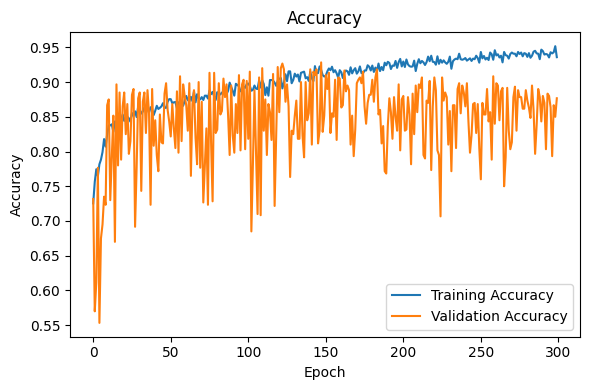

In [72]:
plt.figure(figsize=(6, 4))

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Loss plot
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

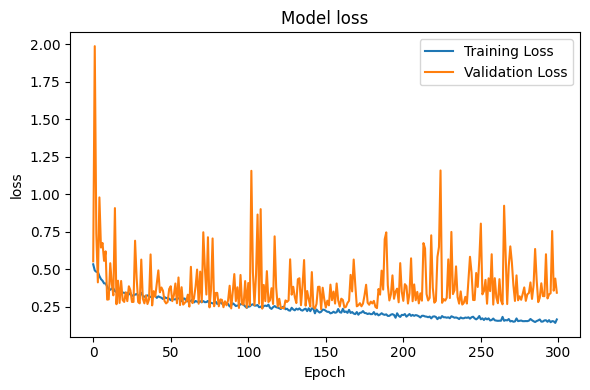

In [73]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Model loss')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
# loading model
model = keras.models.load_model(f"3D_CNN_{BATCH_SIZE}_{EPOCHS}.h5")



# evaluating on validation data
model.evaluate(val_gen)

1/1 [==============================] - 1s 656ms/step - loss: 3.4819 - acc: 0.5000


[3.4819202423095703, 0.5]

In [74]:
# Making predictions on validation data

predictions = model.predict(val_gen, verbose=1)
print(len(predictions))
y_val_pred = predictions.argmax(axis=1)
y_true_val = df_val['class']

150/150 [==============================] - 58s 385ms/step
600


In [75]:
# evaluating prediction on mentioned metrics
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import accuracy_score,f1_score

print('Accuracy :', round(accuracy_score(y_true_val, y_val_pred)*100,3),"%")
print('Precision:', round(precision_score(y_true_val, y_val_pred, average='macro')*100,3),"%")
print('Recall   :', round(recall_score(y_true_val, y_val_pred, average='macro')*100,3),"%")
print('F1-score :', round(f1_score(y_true_val, y_val_pred, average='macro')*100,3),"%")

Accuracy : 87.667 %
Precision: 88.1 %
Recall   : 87.667 %
F1-score : 87.631 %


In [76]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Assuming y_true_val and y_val_pred are your true labels and predicted labels respectively

accuracy = round(accuracy_score(y_true_val, y_val_pred) * 100, 3)
precision = round(precision_score(y_true_val, y_val_pred, average='macro') * 100, 3)

recall = round(recall_score(y_true_val, y_val_pred, average='macro') * 100, 3)
f1 = round(f1_score(y_true_val, y_val_pred, average='macro') * 100, 3)

conf_matrix = confusion_matrix(y_true_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

print('Accuracy :', accuracy, "%")
print('Precision:', precision, "%")
print('Recall   :', recall, "%")
print('F1-score :', f1, "%")

class_report = classification_report(y_true_val, y_val_pred)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[279  21]
 [ 53 247]]
Accuracy : 87.667 %
Precision: 88.1 %
Recall   : 87.667 %
F1-score : 87.631 %

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       300
           1       0.92      0.82      0.87       300

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



In [ ]:
# creating an adam optimizer object with learning rate = 2e-3
optimizer = keras.optimizers.Adamax()
# compiling model
model.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
EPOCHS = 300 #try playing with different number of epochs and batch sizes to see how the score changes
BATCH_SIZE = 16

history1 = model.fit(train_gen,
          validation_data = val_gen,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/300
600/600 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8704
Epoch 1: val_accuracy did not improve from 0.92833
600/600 [==============================] - 663s 1s/step - loss: 0.3151 - accuracy: 0.8704 - val_loss: 0.7408 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 2/300
600/600 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.8963
Epoch 2: val_accuracy did not improve from 0.92833
600/600 [==============================] - 657s 1s/step - loss: 0.2530 - accuracy: 0.8963 - val_loss: 0.3819 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 3/300
600/600 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9013
Epoch 3: val_accuracy did not improve from 0.92833
600/600 [==============================] - 657s 1s/step - loss: 0.2629 - accuracy: 0.9013 - val_loss: 1.1082 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 4/300
600/600 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9100
Epoch 4: val_accuracy di